In [ ]:
import copy
import drjit as dr
import matplotlib.pyplot as plt
import matplotlib.patches
import math
import mitsuba as mi
from pathlib import Path
from typing import List, Tuple

mi.set_variant('cuda_ad_rgb')

from mimt import *
set_siggraph_font()

def to_3d_ray(ray: mi.Ray2f):
    return mi.Ray3f(mi.Point3f(ray.o.x, ray.o.y, 0), mi.Vector3f(ray.d.x, ray.d.y, 0))

def to_2d_ray(ray: mi.Ray3f):
    return mi.Ray2f(mi.Point2f(ray.o.x, ray.o.y), mi.Vector2f(ray.d.x, ray.d.y))

def plot_ray(ax, ray: mi.Ray2f, is_reference: bool = True, zorder: int = 0):
    ax.scatter(ray.o.x.numpy(), ray.o.y.numpy(),
               color='k',
               alpha=1 if is_reference else 0.5,
               zorder=zorder+2)
    arrow = matplotlib.patches.FancyArrowPatch(
        posA=ray.o.numpy().T[0],
        posB=ray(0.4).numpy().T[0],
        arrowstyle='-|>',
        mutation_scale=10,
        color='k',
        alpha=1 if is_reference else 0.5,
        linewidth=1,
        zorder=zorder
    )
    ax.add_patch(arrow)

def get_shape_circle(shape: dict):
    center = shape.get('center', [0, 0])
    radius = shape.get('radius', 1)
    return center, radius

def to_mitsuba_scene(shapes: List[dict]):
    """ Transform a custom 2D scene to a Mitsuba 3 scene
    """
    scene_dict = {'type': 'scene'}
    for shape_idx, shape in enumerate(shapes):
        if shape['type'] == 'circle':
            center, radius = get_shape_circle(shape)
            scene_dict[f'circle_{shape_idx}'] = {
                'type': 'sphere',
                'radius': radius,
                'center': [center[0], center[1], 0]
            }
        else:
            raise RuntimeError(f"Unknown shape type {shape['type']}")
    return scene_dict

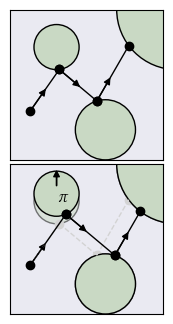

In [5]:
shapes = [
    {'type': 'circle', 'radius': 0.3, 'center': [-0.4, 0.5]},
    {'type': 'circle', 'radius': 0.4, 'center': [0.25, -0.6]},
    {'type': 'circle', 'radius': 0.8, 'center': [1.2, 1.]}
]

origin     = [-0.75, -0.35] # Origin of the path (first vertex)
ωi_samples = [55.,-40, 60]  # Sampled directions, in degree

fig = plt.figure(figsize=(0.3*FIGURE_WIDTH_ONE_COLUMN, 2*0.3*FIGURE_WIDTH_ONE_COLUMN))
gs  = fig.add_gridspec(2, 1, wspace=0, hspace=0.025)

def render_scene(ax, shapes: List[dict], origin: Tuple[float, float], ωi_samples: List[float], is_reference: bool = True):
    ax = disable_ticks(ax)
    ax.set_facecolor('#EAEAF2')
    ax.axis('equal')
    ax.set_ylim(-1, 1)
    ax.set_xlim(-1, 1)

    scene_dict      = to_mitsuba_scene(shapes)
    scene: mi.Scene = mi.load_dict(scene_dict)

    # "Render" the scene geometry
    for shape in shapes:
        if shape['type'] == 'circle':
            center, radius = get_shape_circle(shape)
            shape_mpl = matplotlib.patches.Circle(xy=(center[0], center[1]), radius=radius,
                                                  edgecolor='k',
                                                  facecolor=(201/255, 217/255, 196/255),
                                                  alpha=1 if is_reference else 0.5)
            ax.add_patch(shape_mpl)

    ray = mi.Ray2f(
        o=origin,
        d=mi.Transform3f().rotate(ωi_samples[0]).transform_affine(mi.Vector2f(1, 0))
    )
    for sample_idx, ωi in enumerate(ωi_samples):
        if is_reference:
            plot_ray(ax, ray)

        si = scene.ray_intersect(to_3d_ray(ray))
        ax.scatter(si.p.x.numpy(), si.p.y.numpy(), 
                   color='k' if is_reference else 'lightgray')

        ax.plot([ray.o.numpy()[0], si.p.numpy()[0]], [ray.o.numpy()[1], si.p.numpy()[1]],
                linewidth=1, color='k' if is_reference else 'lightgray', linestyle=None if is_reference else '--')

        if sample_idx < len(ωi_samples) - 1:
            ωi_next = ωi_samples[sample_idx+1]
            d   = mi.Transform3f().rotate(ωi_next).transform_affine(mi.Vector2f(1, 0))
            ray = to_2d_ray(si.spawn_ray(mi.Vector3f(d.x, d.y, 0)))

ax_top = fig.add_subplot(gs[0, 0])
render_scene(ax_top, shapes, origin, ωi_samples)
#ax_top.text(origin[0]+0.15, origin[1]+0.05, r"$\omega_0$", fontsize=12)
shapes_ = copy.deepcopy(shapes)
shapes_[0]['center'][1] += 0.1
ax_bot = fig.add_subplot(gs[1, 0])
render_scene(ax_bot, shapes, origin, ωi_samples, is_reference=False)
render_scene(ax_bot, shapes_, origin, ωi_samples)
ax_bot.annotate(r"$\pi$", (shapes_[0]['center'][0], shapes_[0]['center'][1] + 0.3), (shapes_[0]['center'][0], shapes_[0]['center'][1] - 0.1),
                arrowprops={'headwidth' : 4, 'headlength': 4, 'width': 0.1, 'facecolor': 'k'}, 
                fontsize=12)

output_dir = Path("output")
output_dir.mkdir(exist_ok=True, parents=True)
fig.savefig(output_dir / "moving_path_inset.pdf", dpi=300, bbox_inches='tight')